# Task 1 Backpropagation and Simple Training

In [74]:
import numpy as np
import torch
from tqdm import tqdm #status bar
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

In [79]:
class Linear:
    def __init__(self, in_channels, out_channels):
        self.in_channels = in_channels
        self.out_channels = out_channels

        # The weight matrix needs as many rows, as there are in_channels (assume in_channels is row vector) and as many columns as there are out-channels
        self.weight = torch.randn(in_channels, out_channels)
        self.bias = torch.zeros(out_channels)
        
        self.last_input = None
        self.grad_weight = None
        self.grad_bias = None
        
    def forward(self, x, remember=False):
        if remember:
            self.last_input = x
        # Calculate the output
        #testx = torch.einsum('if,fw -> iw', x, self.weight)+self.bias
        newx = ((x @ self.weight).T + self.bias.view(-1, 1)).T # reshape bias, to make broadcast summation possible
        return newx

    
    # Parameter gradient is ∂Loss/∂Output 
    def backward(self, gradient):
        # Multiply  ∂Output/∂Weight * ∂Loss/∂Output
        self.grad_weight = self.last_input.T @ gradient # (in_channels, out_channels)

        # Since ∂Output/∂Bias = 1, we sum up the gradients since we want to calculate:
        # ∂Loss/∂Output * ∂Output/∂Bias  
        self.grad_bias = gradient.sum(0) # (out_channels,)

        # Calculate ∂Loss/∂Input -> ∂Loss/∂Output * ∂Output/∂Input
        nextGrad = gradient @ self.weight.T # (batch_size, in_channels).
        return nextGrad
    
    def update(self, learning_rate):
        # Avoid exploding gradients by clamping the values
        self.grad_weight = torch.clamp(self.grad_weight, -1e-10, 1e+10)
        self.grad_bias = torch.clamp(self.grad_bias, -1e-10, 1e+10)

        # Calculate the new weights from the common update rule: 
        # w <- w - alpha * (y_pred - y_true) * x
        # the information of (y_pred - y_true) * x is saved in grad_weight, so the final formula is:
        # w <- w - alpha * grad_weight
        self.weight = self.weight - learning_rate * self.grad_weight
        self.bias = self.bias - learning_rate * self.grad_bias
        
        
class ReLU:
    def __init__(self):
        self.last_input = None
    
    def forward(self, x, remember=False):
        if remember:
            self.last_input = x
        
        newx = x.clamp_min(0) # Change all values lower than 0 to 0
        # newx = torch.maximum(x, torch.tensor(0.0)) # Different way to implement it

        return newx
    
    def backward(self, gradient):
        # Calculate ∂Loss/∂Input -> ∂Loss/∂Output * ∂Output/∂Input
        relu_grad = (self.last_input > 0).float() # Calculate a mask that is 1 for input > 0 and 0 otherwise
        newgrad = gradient * relu_grad
        return newgrad
    
    def update(self, learning_rate):
        #we don't have any parameters here
        pass
    
############################################# no need to change anything below this line #############################################    
class Softmax:
    def __init__(self, dim=-1):
        self.last_output = None
        self.dim = dim
        
    def forward(self, x, remember=False):
        x = torch.exp(x-torch.amax(x, dim=-1, keepdims=True)) #numerical stable version -> normalize by max(x)
        x = x/(torch.sum(x, dim=self.dim, keepdim=True)+1e-12)
        if remember:
            self.last_output = x
        return x
    
    def backward(self, gradient):
        jacobian = -self.last_output[:,:,None]*self.last_output[:,None,:] #BxLxL
        #correct diagonal entries. This line is adding the identity matrix scaled by self.last_output to the diagonal of jacobian.
        jacobian += torch.eye(self.last_output.size(-1)).unsqueeze(0)*self.last_output.unsqueeze(-1).repeat(1,1,self.last_output.size(-1))
        # This line is computing the matrix product of gradient and jacobian for each instance in the batch
        
        newgrad = torch.einsum("bj,bji->bi", gradient, jacobian)

        return newgrad
    
    def update(self, learning_rate):
        #we don't have any parameters here
        pass
    
class CrossEntropyLoss:
    def __init__(self, dim=-1):
        self.last_input = None
        self.last_ground_truth = None
        self.dim = dim
    
    def forward(self, p, y):
        #convert y to one hot
        one_hot = torch.eye(p.size(-1))[y]
        self.last_input = p
        self.last_ground_truth = one_hot
        
        # Add a small constant for numerical stability
        p = p.clamp(min=1e-12)
        losses = -torch.sum(one_hot*torch.log(p), dim=-1)
        
        total_loss = torch.mean(losses)
        return total_loss
    
    def backward(self):
        newgrad = torch.where(self.last_ground_truth==1,-1.0/self.last_input, 0.0)
        return newgrad
          
              
class MLP:
    def __init__(self, in_channels=2, hidden_channels=[], out_channels=2):
        self.in_channels = in_channels
        
        self.layers = []
        if len(hidden_channels)==0:
            self.layers.append(Linear(in_channels, out_channels))
        else:
            self.layers.append(Linear(in_channels, hidden_channels[0]))
            self.layers.append(ReLU())
            for i in range(len(hidden_channels)-1):
                self.layers.append(Linear(hidden_channels[i], hidden_channels[i+1]))
                self.layers.append(ReLU())
            self.layers.append(Linear(hidden_channels[-1], out_channels))
        self.layers.append(Softmax(dim=-1))
        
        self.criterion = CrossEntropyLoss(dim=-1)
        
    def forward(self, x, remember=False):
        for layer in self.layers:
            x = layer.forward(x, remember=remember)
            #if torch.isnan(x).any():
            #    print("Warning: nan forward pass detected", type(layer).__name__)
        return x
    
    def backward(self): #calculate gradients
        grad = self.criterion.backward()
        for layer in reversed(self.layers):
            grad = layer.backward(grad) # Go through the derivatives chain
    
    def update(self, learning_rate): #update each layer via gradient descent
        for layer in self.layers:
            layer.update(learning_rate)
    
    def training_step(self, x, y, learning_rate):
        probabilities = self.forward(x, remember=True) #store inputs for backward pass!
        loss = self.criterion.forward(probabilities, y)

        self.backward() #calculate gradients
        self.update(learning_rate) #update using gradient descent
        
        return loss
            
############################################# no need to change anything above this line #############################################  

### Training

##### Create datasets

In [3]:
Ntrain = 8000
Ntest = 2000
Xtrain, ytrain = make_moons(n_samples=Ntrain, noise=0.08, random_state=42)
Xtest, ytest = make_moons(n_samples=Ntest, noise=0.08, random_state=42)

##### Rescale data to [-1,1]

In [4]:
amin = np.amin(Xtrain, axis=0, keepdims=True)
amax = np.amax(Xtrain, axis=0, keepdims=True)
Xtrain = ((Xtrain-amin)/(amax-amin)-0.5)/0.5
Xtest = ((Xtest-amin)/(amax-amin)-0.5)/0.5

##### Train network

In [68]:
def network_run(Xtrain, 
                ytrain, 
                Xtest, 
                ytest, 
                mlp, 
                Ntrain,
                Ntest, 
                batch_size=32, 
                num_epochs=10, 
                learning_rate=5e-2
                ):

    num_batches_train = int(np.ceil(Ntrain/batch_size))
    num_batches_test = int(np.ceil(Ntest/batch_size))

    losses_train = []
    losses_test = []

    for epoch in range(num_epochs):
        #reshuffle training data
        ind = np.random.permutation(len(Xtrain))
        Xtrain = Xtrain[ind]
        ytrain = ytrain[ind]
        #training pass
        for it in tqdm(range(num_batches_train)):
            start = it*batch_size
            end = min((it+1)*batch_size, len(Xtrain))
            X = torch.FloatTensor(Xtrain[start:end])
            y = torch.LongTensor(ytrain[start:end])
            
            losses_train.append(mlp.training_step(X, y, learning_rate))
            #print(losses_train)
            
        #testing pass
        for it in range(num_batches_test):
            start = it*batch_size
            end = min((it+1)*batch_size, len(Xtest))
            X = torch.FloatTensor(Xtest[start:end])
            y = torch.LongTensor(ytest[start:end])
            
            # Perform the test step without any weight updates
            probabilities = mlp.forward(X, remember=False)
            batch_loss = mlp.criterion.forward(probabilities, y)
            losses_test.append(batch_loss)
            
    # VISUALIZATION #
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    x_dim = np.arange(len(losses_train))
    print("Length losses:", len(losses_train))
    print("Minimum loss:", min(losses_train))
    print("Average train loss:", np.mean(losses_train))
    print("Average test loss: ", np.mean(losses_test))
    axs[0].plot(np.arange(len(losses_train)), losses_train, label="train loss")
    axs[0].set_title("Training loss")
    axs[0].set_xlabel("n iterations")
    axs[0].set_ylabel("loss")
    axs[0].set_ylim([0, 1])

    axs[1].plot(np.arange(len(losses_test)), losses_test, label="test loss")
    axs[1].set_title("Test loss")
    axs[1].set_xlabel("n iterations")
    axs[1].set_ylabel("loss")
    axs[1].set_ylim([0, 1])
    plt.show()

100%|██████████| 250/250 [00:00<00:00, 1741.60it/s]


Length losses: 2500
Minimum loss: tensor(0.1456)
Average train loss: 0.3691748
Average test loss:  0.3618974


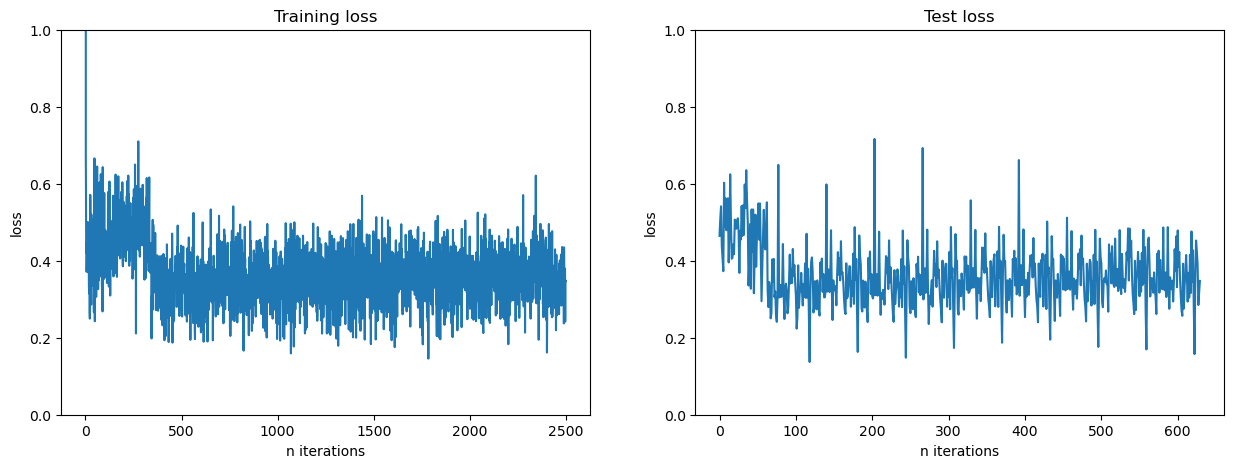

In [80]:
# Hyperparameters
batch_size = 32

num_epochs = 10
mlp = MLP(2, [30,30], 2)
learning_rate = 5e-2

network_run(Xtrain, ytrain, Xtest, ytest, mlp, Ntrain, Ntest, batch_size, num_epochs, learning_rate)

4. Increase numbers of hidden layers by changing hidden_channels=[ ],
which by default is set to [30, 30] and report what you observe on the
training/test loss curves (related to a term we mentioned in the lecture).
(1P)

 62%|██████▏   | 154/250 [00:00<00:00, 769.57it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

100%|██████████| 250/250 [00:00<00:00, 743.83it/s]


torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

  0%|          | 0/250 [00:00<?, ?it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

 58%|█████▊    | 146/250 [00:00<00:00, 727.48it/s]

torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torc

100%|██████████| 250/250 [00:00<00:00, 714.16it/s]


torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

  0%|          | 0/250 [00:00<?, ?it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

 57%|█████▋    | 142/250 [00:00<00:00, 710.10it/s]

torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torc

 86%|████████▌ | 214/250 [00:00<00:00, 511.18it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

100%|██████████| 250/250 [00:00<00:00, 555.81it/s]

torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])



 24%|██▍       | 61/250 [00:00<00:00, 599.64it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

 48%|████▊     | 121/250 [00:00<00:00, 570.81it/s]


torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
t

 75%|███████▍  | 187/250 [00:00<00:00, 608.32it/s]

torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
to

100%|██████████| 250/250 [00:00<00:00, 615.89it/s]


torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])


  0%|          | 0/250 [00:00<?, ?it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

 27%|██▋       | 67/250 [00:00<00:00, 665.14it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

 56%|█████▌    | 139/250 [00:00<00:00, 696.18it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

 84%|████████▎ | 209/250 [00:00<00:00, 528.20it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

100%|██████████| 250/250 [00:00<00:00, 579.52it/s]


torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

  0%|          | 0/250 [00:00<?, ?it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

 26%|██▌       | 64/250 [00:00<00:00, 635.36it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

 52%|█████▏    | 131/250 [00:00<00:00, 652.76it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

 79%|███████▉  | 197/250 [00:00<00:00, 651.03it/s]

torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
to

100%|██████████| 250/250 [00:00<00:00, 649.40it/s]

torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torc


  0%|          | 0/250 [00:00<?, ?it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

 26%|██▌       | 64/250 [00:00<00:00, 500.59it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

 46%|████▌     | 115/250 [00:00<00:00, 441.55it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

 75%|███████▍  | 187/250 [00:00<00:00, 550.50it/s]

torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torc

100%|██████████| 250/250 [00:00<00:00, 563.26it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor


  0%|          | 0/250 [00:00<?, ?it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

 26%|██▌       | 65/250 [00:00<00:00, 645.11it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

 52%|█████▏    | 130/250 [00:00<00:00, 641.58it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

 78%|███████▊  | 195/250 [00:00<00:00, 631.88it/s]

torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
to

100%|██████████| 250/250 [00:00<00:00, 646.05it/s]

torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
tor


  0%|          | 0/250 [00:00<?, ?it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

 13%|█▎        | 33/250 [00:00<00:00, 324.40it/s]

torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torc

 34%|███▍      | 86/250 [00:00<00:00, 442.60it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

 62%|██████▏   | 156/250 [00:00<00:00, 557.48it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

100%|██████████| 250/250 [00:00<00:00, 562.04it/s]


torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
to

  0%|          | 0/250 [00:00<?, ?it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

 28%|██▊       | 71/250 [00:00<00:00, 704.64it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

 57%|█████▋    | 142/250 [00:00<00:00, 505.44it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

 84%|████████▎ | 209/250 [00:00<00:00, 565.28it/s]

torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
tor

100%|██████████| 250/250 [00:00<00:00, 584.51it/s]

torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([30, 30])
torch.Size([2, 30])
torch.Size([30, 2])
torch.Size([30, 30])
torc

Minimum loss: tensor(15.5425)
Average train loss: nan
Average test loss:  nan


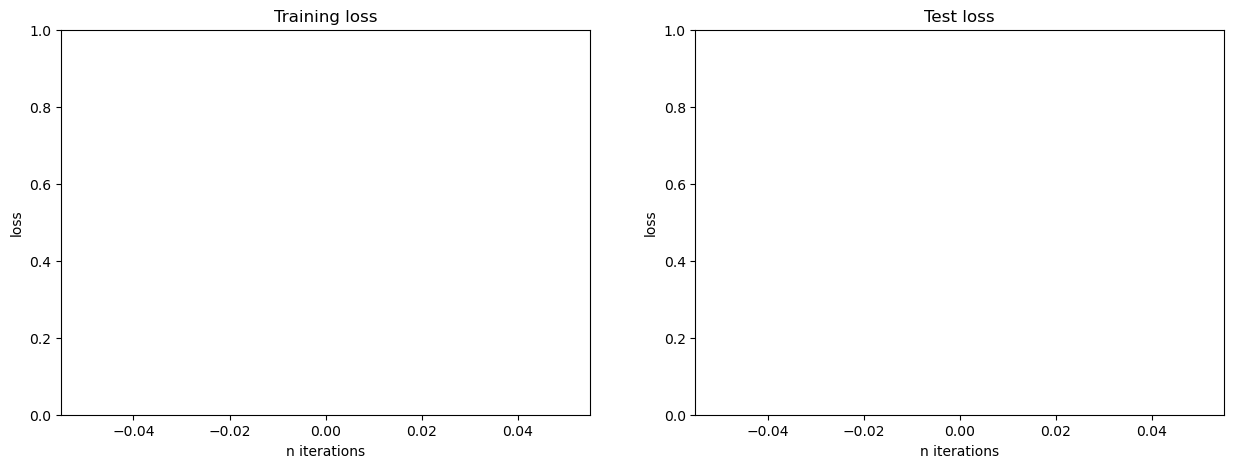

In [64]:
# Hyperparameters
batch_size = 32

num_epochs = 10
mlp = MLP(2, [30, 30, 30, 30, 30, 30, 30, 30], 2)
learning_rate = 5e-2

network_run(Xtrain, ytrain, Xtest, ytest, mlp, Ntrain, Ntest, batch_size, num_epochs, learning_rate)
# The issue I run into here are exploding gradients. Because I make the network too deep, the gradients get so high, that they result in nan values. This breaks the network.
# For me, the gradients explode after only a few iterations, which is also why the plotting is broken. It is a sign for me, that the implementation is not robust enough.

# Task 2: Data Preparation and Visualization

In [8]:
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm  # Not needed but very cool!
import matplotlib.pyplot as plt

c:\Users\adria\anaconda3\envs\genai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def load_data(train=True):
    mnist = datasets.MNIST('../data',
                           train=train,
                           download=True)
    return mnist

1. Using the function load_data, load the train split of MNIST and plot
10 examples of digits with their label as title. Also report the following
statistics about the train set: min, max, mean, shape, dtype. Here, you
can imagine the train set as a large data array and report the statistics on
that array. (1P)

In [10]:
def plot_examples(data):
    # Create a dictionary where the keys are the labels and the values are lists of images with that label
    data_dict = {i: [] for i in range(10)}
    for img, label in data:
        data_dict[label].append((img, label))

    fig, axs = plt.subplots(5, 10, figsize=(15, 5))

    for i in range(10):
        i_number_data = data_dict[i]
        for j in range(5):
            # Select a random number i and plot it with its label as title
            random_index = np.random.choice(len(i_number_data))
            random_img = i_number_data[random_index]
            axs[j][i].imshow(random_img[0], cmap='gray')
            axs[j][i].set_title(f'Label: {random_img[1]}')
            axs[j][i].axis('off')

    plt.tight_layout()
    plt.show()

In [11]:
data = load_data()

# Convert the images to numpy arrays
train_set = [np.array(img) for img, _ in data]

# Stack all images into a single numpy array
train_set = np.stack(train_set)

# Calculate and report min, max, mean, shape and dtype of the train set
print(f'min: {train_set.min()}')
print(f'max: {train_set.max()}')
print(f'mean: {train_set.mean()}')
print(f'shape: {train_set.shape}')
print(f'dtype: {train_set.dtype}')

min: 0
max: 255
mean: 33.318421449829934
shape: (60000, 28, 28)
dtype: uint8


2. Convert all images into plain vectors and process them to be centered around
0 in the range of [-1, 1]. In the end you should have two arrays of images
and labels. (1P)


In [12]:
def convert_mnist_to_vectors(data):
   '''Converts the ``[28, 28]`` MNIST images to vectors of size ``[28*28]``.
      It outputs mnist_vectors as a array with the shape of [N, 784], where
      N is the number of images in data.
   '''
   mnist_vectors = []
   labels = []

   #########################
   #### Your Code here  ####
   #########################
   
   # Convert the mnist images into numpy arrays of the shape (N, 28*28) and (N,)
   Xtrain = data.data.numpy()
   Xtrain = Xtrain.reshape(len(Xtrain), -1)
   ytrain = data.targets.numpy()
   print("Xtrain:", Xtrain.shape)
   print("ytrain:", ytrain.shape)

   max = 255
   min = 0
   # Center data around 0 in the range of [-1, 1]
   Xtrain_norm = ((Xtrain - max) / (max - min) - 0.5) / 0.5
   
   print("Minimum:", np.min(Xtrain_norm))
   print("Maximum:", np.max(Xtrain_norm))

   return Xtrain_norm, ytrain

3. Now run the provided do_pca on the converted data in order to obtain
a matrix of sorted eigenvectors that represent the principal components of
the train set. Reshape the 10 most important principal components to the
shape of [28, 28] in order to plot them as images. Explain what you are seeing. What would you expect the principal components to look like, if
the problem was easy? (1P)

In [13]:
def do_pca(Xtrain_norm):
    '''Returns matrix [784x784] whose columns are the sorted eigenvectors.
       Eigenvectors (prinicipal components) are sorted according to their
       eigenvalues in decreasing order.
    '''

    #print("pca_input", Xtrain_norm)
    # compute covariance matrix of data with shape [784x784]
    cov = np.cov(Xtrain_norm.T)

    # compute eigenvalues and vectors
    eigVals, eigVec = np.linalg.eig(cov)

    # sort eigenVectors by eigenValues
    sorted_index = eigVals.argsort()[::-1]
    eigVals = eigVals[sorted_index]
    sorted_eigenVectors = eigVec[:, sorted_index]
    return sorted_eigenVectors.astype(np.float32).T

In [14]:
def plot_pcs(sorted_eigenVectors, num=10):
    '''Plots the first ``num`` eigenVectors as images.'''

    #########################
    #### Your Code here  ####
    #########################


    fig, axs = plt.subplots(2, 5, figsize=(15, 5))
    for i in range(num):
        eigenvector = sorted_eigenVectors[i]
        eigen_image = eigenvector.reshape(28, 28)

        y_axis = i // 5
        x_axis = i % 5
        axs[y_axis][x_axis].imshow(eigen_image, cmap='gray')
        axs[y_axis][x_axis].set_title(f'Principal Component: {i}')
        axs[y_axis][x_axis].axis('off')


4. Project the MNIST vectors of the train set onto the two most important
principal components (associated with two largest eigenvalues). Use the dot
product for the projection into the 2D feature space spanned by the two
principal components and plot the resulting points in a scatter (use the
scatter provided by matplotlib for this) plot. To get a better overview you
can also choose a subset of the points. Color each dot corresponding to its
class. Interpret the plot. What can it tell us about the MNIST dataset? Can
you make a statement regarding the difficulty of MNIST digit classification
problem? (1P)

In [15]:
def plot_projection(sorted_eigenVectors, Xtrain_norm, ytrain):
    '''Projects ``data`` onto the first two ``sorted_eigenVectors`` and makes
    a scatterplot of the resulting points'''

    print(np.array(Xtrain_norm).shape)
    # Take the first 2 principal component eigenvectors
    first_eigenVector = sorted_eigenVectors[0]
    second_eigenVector = sorted_eigenVectors[1]

    # Calculate the 2 projections
    first_projection = Xtrain_norm @ first_eigenVector
    second_projection = Xtrain_norm @ second_eigenVector

    # Plot the result in a scatter plot
    plt.figure()
    scatter = plt.scatter(first_projection, second_projection, c=ytrain, cmap='tab10')
    plt.xlabel("projection 1")
    plt.ylabel("projection 2")
    plt.colorbar(scatter)
    plt.show()



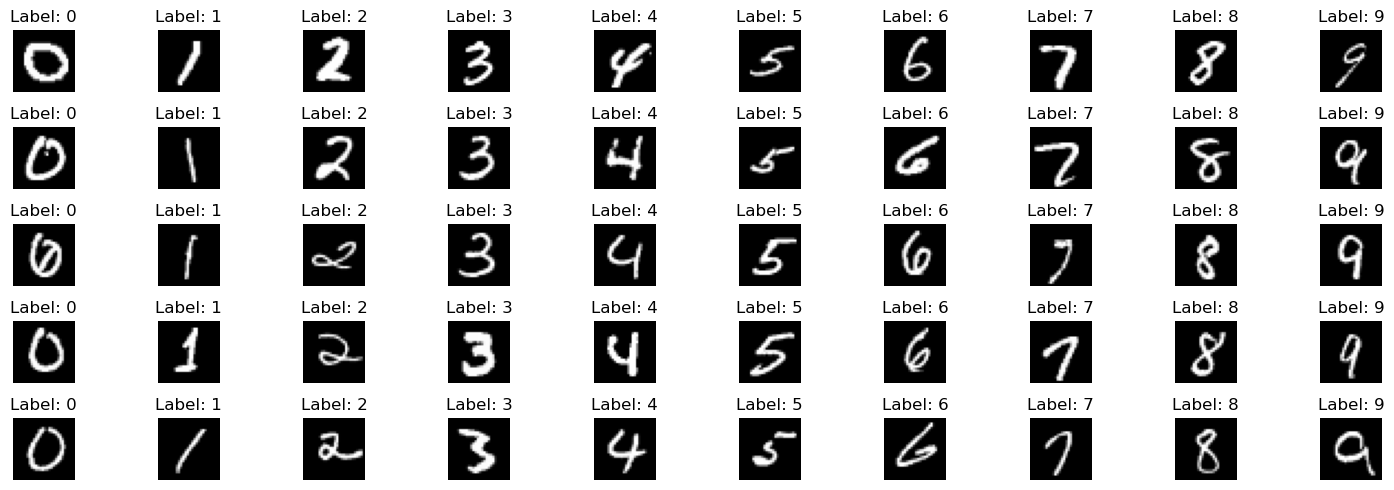

Xtrain: (60000, 784)
ytrain: (60000,)
Minimum: -1.0
Maximum: 1.0


In [16]:
if __name__ == '__main__':
    # You can run this part of the code from the terminal using python ex1.py
    # dataloading
    data = load_data()

    # subtask 1
    plot_examples(data)

    # subtask 2
    Xtrain_norm, ytrain = convert_mnist_to_vectors(data)


In [17]:
print(Xtrain_norm.shape)

(60000, 784)


C:\Users\adria\AppData\Local\Temp\ipykernel_9888\1384496124.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  return sorted_eigenVectors.astype(np.float32).T


(60000, 784)


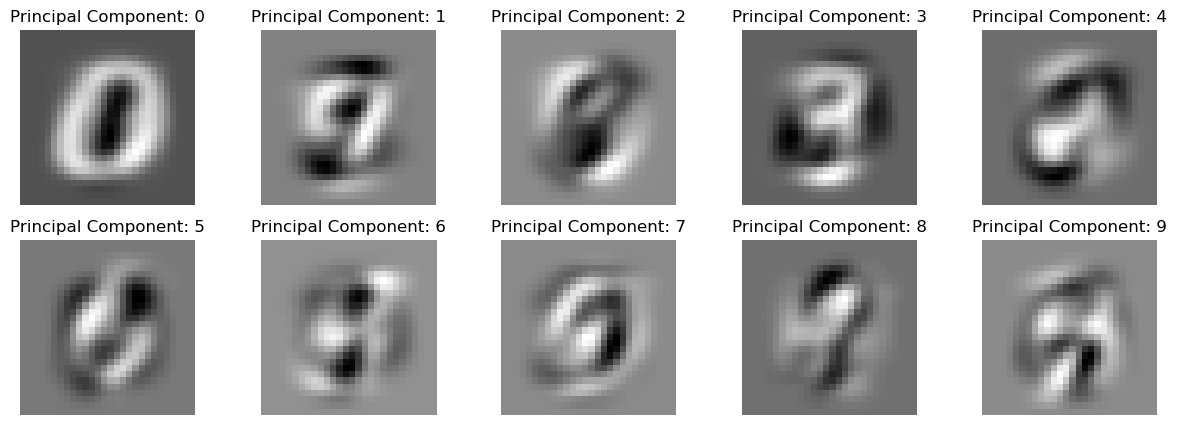

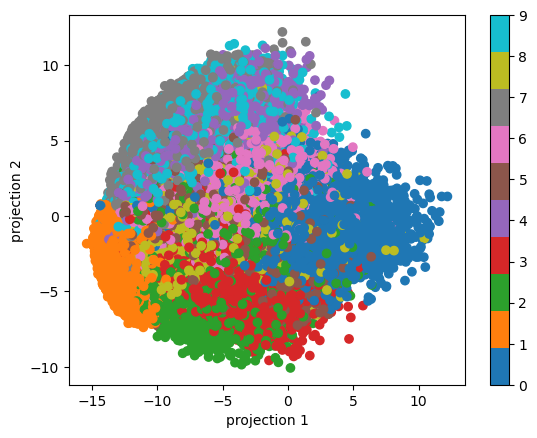

In [18]:
# subtask 3
pcs = do_pca(Xtrain_norm)

# subtask 3
plot_pcs(pcs)

# subtask 4
plot_projection(pcs, Xtrain_norm, ytrain)

3. I can see a lot of blurry shapes in the middle of the images. They seem to represent common strokes from the digits. At the corners, the variance is very low there. It seems that the pixels in the center creatly contribute the the principal component.

If the problem would be an easy one, then the first principal components could capture the shapes of the original images very well. All of the digits would be separated clearly from each other.

4. The number zero is well separated from all the other numbers. It suggests, that the first 2 principal componets can distinguish the number 0 and 1 well from the rest of the numbers, but aren't very proficient on distinguishing the rest of the numbers from each other. 

Since the 2 most important principal componants can only distinguish the numbers 0 and 1 well from the other digits, the classification problem seems to be not a trivial one.

# Task 3: Defining, Training and Evaluating an MLP + Task 4: Visualizing MLP Features

In [19]:
from torchvision import datasets
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

The first thing to do is specify our model. The multilayer perceptron does a matrix<br>
multiplication of its internal weights with the inputs and adds a bias in<br>
each layer. After that it activates the resulting vector.<br>
This can be done using the `Linear` layer. <br>
Our model itself will be implemented in an object-oriented manner. You can<br>
find a skeleton implementation below. Please fill in the blanks marked with<br>
`# Your code here`. As we want to use mnist vectors as input data, make sure<br>
to pass the correct dimensions to the `Linear` module. 

As our multilayer perceptron is a pytorch module, it has to inherit from the base<br>
`nn.Module`.  All pytorch modules expect at least a `forward` method, which<br>
defines what happens, when you call the instance of such a module on some<br>
data.

In [20]:
class MultilayerPerceptron(nn.Module):
    
    def __init__(self, size_hidden=100, size_out=10):
        super().__init__()
        
        self.fc1 = nn.Linear(28*28, size_hidden)
        self.fc2 = nn.Linear(size_hidden, size_hidden)
        self.fc3 = nn.Linear(size_hidden, size_hidden)
        self.fc4 = nn.Linear(size_hidden, size_hidden)
        self.out_layer = nn.Linear(size_hidden, size_out)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # All layers of the NN in sequential
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        # Do not apply relu function on last layer to become a linear output
        out = self.out_layer(out)
        return out

Pytorch modules keep track of all model parameters internally. Those will be<br>
e.g. the matrix and bias of the `Linear` operation we just implemented.

To be able to feed the mnist vectors to our MultilayerPerceptron we first have to<br>
convert them to `torch.Tensor`s. To not have to do this everytime we want to<br>
do an operation on those vectors you can find a `torch.Dataset` version of<br>
the mnist vectors below. All it does is a simple casting operation.

In [21]:
# Conversion function from task 2
def convert_mnist_to_vectors(data):
   '''Converts the ``[28, 28]`` MNIST images to vectors of size ``[28*28]``.
      It outputs mnist_vectors as a array with the shape of [N, 784], where
      N is the number of images in data.
   '''
   mnist_vectors = []
   labels = []

   #########################
   #### Your Code here  ####
   #########################
   
   # Convert the mnist images into numpy arrays of the shape (N, 28*28) and (N,)
   Xtrain = data.data.numpy()
   Xtrain = Xtrain.reshape(len(Xtrain), -1)
   ytrain = data.targets.numpy()
   print("Xtrain:", Xtrain.shape)
   print("ytrain:", ytrain.shape)

   max = 255
   min = 0
   # Center data around 0 in the range of [-1, 1]
   Xtrain_norm = ((Xtrain - max) / (max - min) - 0.5) / 0.5
   
   print("Minimum:", np.min(Xtrain_norm))
   print("Maximum:", np.max(Xtrain_norm))

   return Xtrain_norm, ytrain

In [22]:
class MnistVectors(torch.utils.data.Dataset):
    '''A Pytorch Dataset, which does the same data preparation as was done in
    the PCA exercise.'''
    def __init__(self, split='train'):
        super().__init__()
        
        mnist = datasets.MNIST('../data',
                               train=split=='train',
                               download=True)

        ########################
        #### Your Code here ####
        self.mnist_vectors, self.labels = convert_mnist_to_vectors(mnist)
        ########################
            
    def __getitem__(self, idx):
        '''Implements the ``[idx]`` method. Here we convert the numpy data to
        torch tensors.
        '''
        mvec = torch.tensor(self.mnist_vectors[idx]).float()
        label = torch.tensor(self.labels[idx]).long()
        return mvec, label
    
    def __len__(self):
        return len(self.labels)

The following two functions are needed to track the progress of the training.<br>
One transforms the output of the MultilayerPerceptron into a scalar class label, the <br>
other uses that label to calculate the batch accuracy.

In [23]:
def batch_accuracy(prediction, label):
    # Calculate the mean of all predicions compared with the true labels
    return (prediction == label).float().mean()

In [24]:
def class_label(prediction):
    return prediction.argmax(1) # return the classlabel of the highest value in each row

In [25]:
def train(use_gpu=False): # if torch.cuda.is_available(), use gpu to speed up training
    
    # Here we instantiate our model. The weights of the model are automatically
    # initialized by pytorch
    P = MultilayerPerceptron()
    epochs = 5
    TrainData = MnistVectors()
    TestData = MnistVectors('test')
    # Dataloaders allow us to load the data in batches. This allows us a better
    # estimate of the parameter updates when doing backprop.
    # We need two Dataloaders so that we can train on the train data split
    # and evaluate on the test datasplit.
    Dl = DataLoader(TrainData, batch_size=16, shuffle=True)
    testDl = DataLoader(TestData, batch_size=16, shuffle=False)
    
    # Use the Adam optimizer with learning rate 1e-4 and otherwise default
    # values
    optimizer =  torch.optim.Adam(params=P.parameters(), lr=1e-4)
    # Use the Cross Entropy loss from pytorch. Make sure your MultilayerPerceptron does
    # not use any activation function on the output layer! (Do you know why?)
    criterion =  nn.CrossEntropyLoss()
    
    if use_gpu:
        P.cuda()
        criterion.cuda()


    # 4.1 Initialize list with the layer names and the activations
    layer_names = ['fc1', 'fc2', 'fc3', 'fc4']
    activations = [ [], [], [], [] ]

    # Define callback hook, that will get called on every forward pass of the layer where it is attached to
    def get_activation(layer_number):
        def hook(module, input, output):
            # Retrieve the output from the linear layer and calculate the calculate the relu output from it
            linear_output = output.detach()
            relu_output = torch.relu(linear_output).cpu() # We need cpu() here, or all the data will fill up gpu memory
            activations[layer_number].append(relu_output)
        return hook

    for epoch in tqdm(range(epochs), desc='Epoch'):
        for step, [example, label] in enumerate(tqdm(Dl, desc='Batch')):
            if use_gpu:
                example = example.cuda()
                label = label.cuda()
            
            # The optimizer knows about all model parameters. These in turn
            # store their own gradients. When calling loss.backward() the newly
            # computed gradients are added on top of the existing ones. Thus
            # at before calculating new gradients we need to clear the old ones
            # using ther zero_grad() method.
            optimizer.zero_grad()
            
            prediction = P(example)
            
            loss = criterion(prediction, label)
            
            # Here pytorch applies backpropagation for us completely
            # automatically!!! That is quite awesome!
            loss.backward()

            # The step method now adds the gradients onto the model parameters
            # as specified by the optimizer and the learning rate.
            optimizer.step()
            
            # To keep track of what is happening print some outputs from time
            # to time.
            if (step % 375) == 0:
                # Your code here
                acc = batch_accuracy(class_label(prediction), label)
                tqdm.write('Batch Accuracy: {:.2f}%, Loss: {:.2f}'.format(acc, loss))
                
        # Now validate on the whole test set
        test_accuracies = []

        # Task 4.1 Add the forward hooks onto the linear layers to get their outputs
        if(epoch == epochs-1):
            for index, layer_name in enumerate(layer_names):
                getattr(P, layer_name).register_forward_hook(get_activation(index))


        test_labels = []
        for idx, [test_ex, test_l] in enumerate(tqdm(testDl, desc='Test')):
            if use_gpu:
                test_ex = test_ex.cuda()
                test_l = test_l.cuda()

             # Store the labels
            test_labels.extend(test_l.cpu().tolist())

            P.eval()
            # Don't calculate gradients for testing
            with torch.no_grad():
                prediction = P(test_ex)
                test_accuracies.append(batch_accuracy(class_label(prediction), test_l))

        # Using your batch_accuracy function, also print the mean accuracy
        # over the whole test split of the data.
        test_accuracies_tensor = torch.tensor(test_accuracies) # Convert the list of accuracies back to a tensor
        print('Validation Accuracy: {:.2f}%'.format(test_accuracies_tensor.mean().item()))

        # Now let's write out a checkpoint of the model, so that we can
        # reuse it:
        torch.save(P.state_dict(), 'perceptron_{}.ckpt'.format(step))

        # If you need to load the checkpoint instanciate your model and the
        # load the state dict from a checkpoint:
        # P = MultilayerPerceptron()
        # P.load_state_dict(torch.load(perceptron_3750.ckpt))
        # Make sure to use the latest checkpoint by entering the right number.

    # Reshape array from 4 x 6260 x 16 x 100 to 4 x 10000 x 100
    activations = np.array(activations)
    new_activations = activations.reshape(4, 10000, 100)

    # Plot the projection of the relu activations onto their eigenvectors
    for index, activation in enumerate(new_activations):
        eigenvectors = do_pca(np.array(activation))
        print("###################################################")
        print("Plot for layer", layer_names[index])
        print("###################################################")
        plot_projection(eigenvectors, activation, test_labels)

In [26]:
print(torch.cuda.is_available())
print(torch.version.cuda)


True
11.8


Xtrain: (60000, 784)
ytrain: (60000,)
Minimum: -1.0
Maximum: 1.0
Xtrain: (10000, 784)
ytrain: (10000,)
Minimum: -1.0
Maximum: 1.0


                                            
Batch:   3%|▎         | 94/3750 [00:00<00:11, 322.89it/s]

Batch Accuracy: 0.06%, Loss: 2.32


                                            
Batch:  13%|█▎        | 473/3750 [00:01<00:07, 461.57it/s]

Batch Accuracy: 0.56%, Loss: 1.31


                                            
Epoch:   0%|          | 0/5 [00:01<?, ?it/s]              

Batch Accuracy: 0.69%, Loss: 0.86


                                            
Epoch:   0%|          | 0/5 [00:02<?, ?it/s]               

Batch Accuracy: 0.94%, Loss: 0.34


                                            
Epoch:   0%|          | 0/5 [00:03<?, ?it/s]               

Batch Accuracy: 0.88%, Loss: 0.55


                                            
Epoch:   0%|          | 0/5 [00:04<?, ?it/s]               

Batch Accuracy: 0.94%, Loss: 0.59


                                            
Epoch:   0%|          | 0/5 [00:05<?, ?it/s]               

Batch Accuracy: 0.62%, Loss: 0.89


                                            
Epoch:   0%|          | 0/5 [00:05<?, ?it/s]               

Batch Accuracy: 0.81%, Loss: 0.65


                                            
Epoch:   0%|          | 0/5 [00:06<?, ?it/s]               

Batch Accuracy: 0.94%, Loss: 0.32


                                            
Epoch:   0%|          | 0/5 [00:07<?, ?it/s]               

Batch Accuracy: 0.88%, Loss: 0.28


Epoch:  20%|██        | 1/5 [00:09<00:36,  9.12s/it]

Validation Accuracy: 0.89%


                                                    
Epoch:  20%|██        | 1/5 [00:09<00:36,  9.12s/it]

Batch Accuracy: 0.88%, Loss: 0.42


                                                    
Batch:  11%|█▏        | 429/3750 [00:01<00:10, 317.83it/s]

Batch Accuracy: 0.69%, Loss: 0.70


                                                    
Batch:  22%|██▏       | 838/3750 [00:02<00:06, 416.23it/s]

Batch Accuracy: 1.00%, Loss: 0.15


                                                    
Epoch:  20%|██        | 1/5 [00:12<00:36,  9.12s/it]       

Batch Accuracy: 1.00%, Loss: 0.06


                                                    
Batch:  42%|████▏     | 1581/3750 [00:04<00:05, 429.05it/s]

Batch Accuracy: 0.88%, Loss: 0.34


                                                    
Epoch:  20%|██        | 1/5 [00:14<00:36,  9.12s/it]       

Batch Accuracy: 0.88%, Loss: 0.64


                                                    
Batch:  61%|██████▏   | 2301/3750 [00:06<00:04, 295.69it/s]

Batch Accuracy: 0.81%, Loss: 0.48


                                                    
Epoch:  20%|██        | 1/5 [00:16<00:36,  9.12s/it]       

Batch Accuracy: 0.94%, Loss: 0.27


                                                    
Epoch:  20%|██        | 1/5 [00:17<00:36,  9.12s/it]       

Batch Accuracy: 0.88%, Loss: 0.25


                                                    
Epoch:  20%|██        | 1/5 [00:18<00:36,  9.12s/it]       

Batch Accuracy: 0.81%, Loss: 0.61


Epoch:  40%|████      | 2/5 [00:20<00:30, 10.33s/it]

Validation Accuracy: 0.91%


                                                    
Epoch:  40%|████      | 2/5 [00:20<00:30, 10.33s/it]

Batch Accuracy: 0.88%, Loss: 0.30


                                                    
Epoch:  40%|████      | 2/5 [00:21<00:30, 10.33s/it]      

Batch Accuracy: 0.94%, Loss: 0.18


                                                    
Epoch:  40%|████      | 2/5 [00:22<00:30, 10.33s/it]      

Batch Accuracy: 0.94%, Loss: 0.21


                                                    
Epoch:  40%|████      | 2/5 [00:23<00:30, 10.33s/it]       


Batch Accuracy: 0.75%, Loss: 0.55


                                                    87it/s]
Epoch:  40%|████      | 2/5 [00:24<00:30, 10.33s/it]       

Batch Accuracy: 0.81%, Loss: 0.38


                                                    
Epoch:  40%|████      | 2/5 [00:25<00:30, 10.33s/it]       

Batch Accuracy: 0.94%, Loss: 0.16


                                                    
Epoch:  40%|████      | 2/5 [00:26<00:30, 10.33s/it]       

Batch Accuracy: 0.94%, Loss: 0.27


                                                    
Epoch:  40%|████      | 2/5 [00:27<00:30, 10.33s/it]       

Batch Accuracy: 0.88%, Loss: 0.79


                                                    
Epoch:  40%|████      | 2/5 [00:28<00:30, 10.33s/it]       

Batch Accuracy: 0.81%, Loss: 0.58


                                                    
Epoch:  40%|████      | 2/5 [00:29<00:30, 10.33s/it]       

Batch Accuracy: 0.88%, Loss: 0.34


Epoch:  60%|██████    | 3/5 [00:30<00:20, 10.46s/it]

Validation Accuracy: 0.92%


                                                    
Epoch:  60%|██████    | 3/5 [00:30<00:20, 10.46s/it]

Batch Accuracy: 1.00%, Loss: 0.09


                                                    
Epoch:  60%|██████    | 3/5 [00:32<00:20, 10.46s/it]      

Batch Accuracy: 0.88%, Loss: 0.60


                                                    
Batch:  22%|██▏       | 824/3750 [00:02<00:07, 383.23it/s]

Batch Accuracy: 1.00%, Loss: 0.11


                                                    
Batch:  32%|███▏      | 1197/3750 [00:03<00:06, 395.12it/s]

Batch Accuracy: 0.94%, Loss: 0.28


                                                    
Epoch:  60%|██████    | 3/5 [00:35<00:20, 10.46s/it]       

Batch Accuracy: 1.00%, Loss: 0.02


                                                    
Epoch:  60%|██████    | 3/5 [00:36<00:20, 10.46s/it]       

Batch Accuracy: 0.81%, Loss: 0.36


                                                    
Epoch:  60%|██████    | 3/5 [00:37<00:20, 10.46s/it]       

Batch Accuracy: 0.88%, Loss: 0.17


                                                    
Epoch:  60%|██████    | 3/5 [00:38<00:20, 10.46s/it]       

Batch Accuracy: 0.94%, Loss: 0.15


                                                    
Epoch:  60%|██████    | 3/5 [00:39<00:20, 10.46s/it]       

Batch Accuracy: 0.88%, Loss: 0.32


                                                    
Epoch:  60%|██████    | 3/5 [00:40<00:20, 10.46s/it]       

Batch Accuracy: 0.88%, Loss: 0.32


Epoch:  80%|████████  | 4/5 [00:41<00:10, 10.67s/it]

Validation Accuracy: 0.93%


                                                    
Epoch:  80%|████████  | 4/5 [00:41<00:10, 10.67s/it]

Batch Accuracy: 1.00%, Loss: 0.03


                                                    
Batch:  12%|█▏        | 443/3750 [00:01<00:10, 326.72it/s]

Batch Accuracy: 1.00%, Loss: 0.08


                                                    
Epoch:  80%|████████  | 4/5 [00:44<00:10, 10.67s/it]      

Batch Accuracy: 0.94%, Loss: 0.33


                                                    
Epoch:  80%|████████  | 4/5 [00:45<00:10, 10.67s/it]       


Batch Accuracy: 0.88%, Loss: 0.23


                                                    48it/s]
Batch:  42%|████▏     | 1587/3750 [00:04<00:05, 413.87it/s]

Batch Accuracy: 1.00%, Loss: 0.08


                                                    
Epoch:  80%|████████  | 4/5 [00:46<00:10, 10.67s/it]       

Batch Accuracy: 0.94%, Loss: 0.10


                                                    
Epoch:  80%|████████  | 4/5 [00:48<00:10, 10.67s/it]       

Batch Accuracy: 1.00%, Loss: 0.09


                                                    
Batch:  72%|███████▏  | 2717/3750 [00:07<00:02, 425.74it/s]

Batch Accuracy: 0.88%, Loss: 0.31


                                                    
Epoch:  80%|████████  | 4/5 [00:49<00:10, 10.67s/it]       

Batch Accuracy: 1.00%, Loss: 0.08


                                                    
Batch:  92%|█████████▏| 3463/3750 [00:08<00:00, 430.54it/s]

Batch Accuracy: 0.94%, Loss: 0.22


Epoch: 100%|██████████| 5/5 [00:52<00:00, 10.55s/it]


Validation Accuracy: 0.94%
###################################################
Plot for layer fc1
###################################################
(10000, 100)


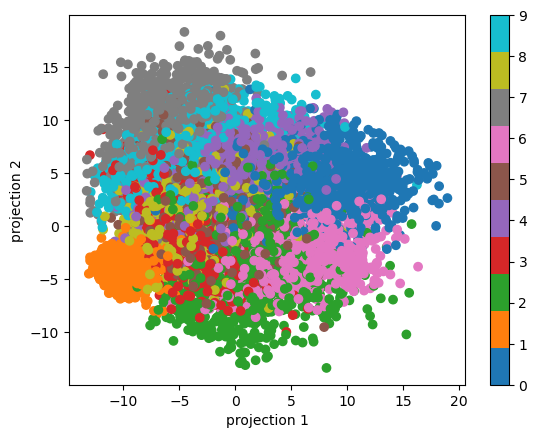

###################################################
Plot for layer fc2
###################################################
(10000, 100)


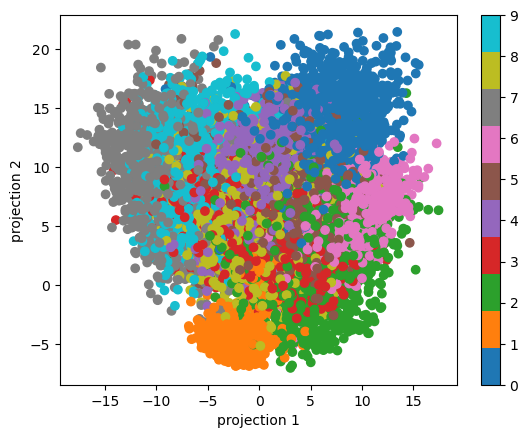

###################################################
Plot for layer fc3
###################################################
(10000, 100)


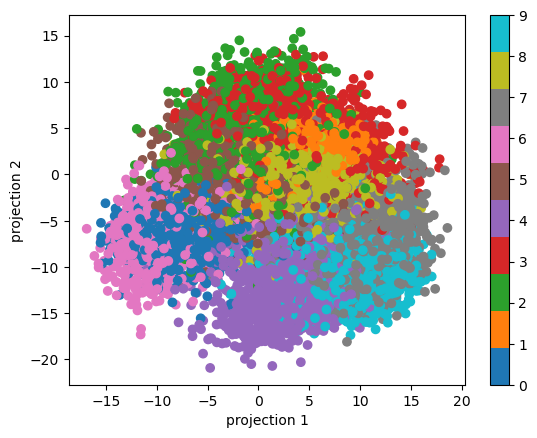

###################################################
Plot for layer fc4
###################################################
(10000, 100)


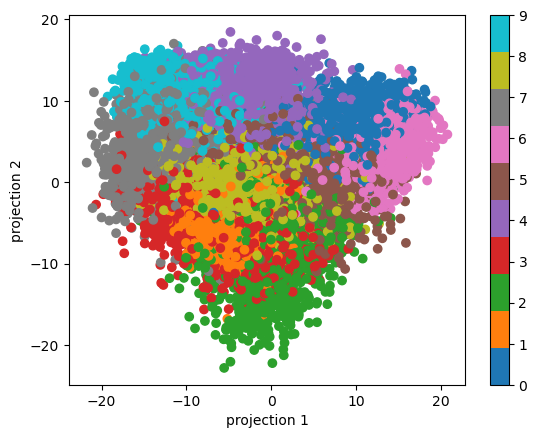

In [27]:
if __name__ == '__main__':
    train(use_gpu=True if torch.cuda.is_available() else False)

Task 4.3: Most numbers are well separated from each other. This goes for: 0, 1, 4, 6, 7, 9
- The digits 2 and 3 are well separated from the rest, but have some overlap with each other. This also makes sense, since they have a relatively similare shape.
- The digits 5, 8 do have quite a big of an overlap with each other. Especially 5 seems to have no shape and is spread all over the scatter plot

Task 4.4: Here, more digits are distinctly separated from each other. In the plot of task 2 only the digits 0 and 1 were well separated from the rest of the digits. If a high accuracy is necessary, then I think that the model is not suitable to be used for MNIST digit classification. It achieves around 94% accuracy on the test set, which is not enough for a lot of tasks like optical character recognition for postal codes.